In [12]:
from PIL import Image
import kraken
from kraken import binarization
from kraken import blla
from kraken import serialization
from kraken.lib import vgsl
import os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

# 2024-10-25 19:42:03.146647: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

In [19]:
pwd

'/home/natalkaser/mmp/Potanin/strokes_cut'

In [14]:
!which python

/home/natalkaser/mmp/Potanin/strokes_cut/env3.8strokes/bin/python


In [7]:
!pip install kraken

  Using cached pillow-10.4.0-cp38-cp38-manylinux_2_28_x86_64.whl.metadata (9.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 119.6 kB/s eta 0:00:001m703.5 kB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 270.6 kB/s eta 0:00:00 kB/s eta 0:00:01
  Using cached torchvision-0.19.1-cp38-cp38-manylinux1_x86_64.whl.metadata (6.0 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 841.8 kB/s eta 0:00:0031m1.1 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 256.9 kB/s eta 0:00:00 kB/s eta 0:00:0101
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 387.7 kB/s eta 0:00:001m741.7 kB/s eta 0:00:01
  Using cached networkx-3.1-py3-none-any.whl.metadata (5.3 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime

In [21]:
# filename = 'datasets/litke/valid/images/1_6.png'
filename = '/home/natalkaser/mmp/Potanin/КККМ/КККМ ОФ 7928:19 Анучин В.jpeg'

In [22]:
model_path = 'blla.mlmodel'
model = vgsl.TorchVGSLModel.load_model(model_path)

In [23]:
img = Image.open(filename)

In [24]:
bw = binarization.nlbin(img)

In [25]:
baseline_seg = blla.segment(bw, model=model, device='cuda')

RuntimeError: No CUDA GPUs are available

In [7]:
baseline_seg.lines

[BaselineLine(id='2665cc83-bbbd-4f9c-b474-0440ae6b01ed', baseline=[[13, 1051], [24, 1060], [28, 1091]], boundary=[[48, 1060], [51, 1040], [13, 1051], [0, 1053], [2, 1071], [2, 1071], [8, 1093], [28, 1091], [46, 1084], [48, 1060]], text=None, base_dir=None, type='baselines', imagename=None, tags={'type': 'default'}, split=None, regions=['2404aa4c-b7e6-4996-9356-ca4035f02727']),
 BaselineLine(id='94d964d1-eb93-426f-88b8-ea6475e0f794', baseline=[[11, 1164], [37, 1164]], boundary=[[11, 1184], [35, 1188], [37, 1164], [37, 1126], [13, 1115], [11, 1164], [11, 1184]], text=None, base_dir=None, type='baselines', imagename=None, tags={'type': 'default'}, split=None, regions=['2404aa4c-b7e6-4996-9356-ca4035f02727']),
 BaselineLine(id='2c015105-5df7-4731-814a-de37f32dac20', baseline=[[17, 2008], [20, 2022]], boundary=[[17, 2008], [2, 2008], [0, 2013], [0, 2017], [20, 2022], [46, 2008], [42, 2002], [17, 2008]], text=None, base_dir=None, type='baselines', imagename=None, tags={'type': 'default'}, sp

NameError: name 'baseline_seg' is not defined

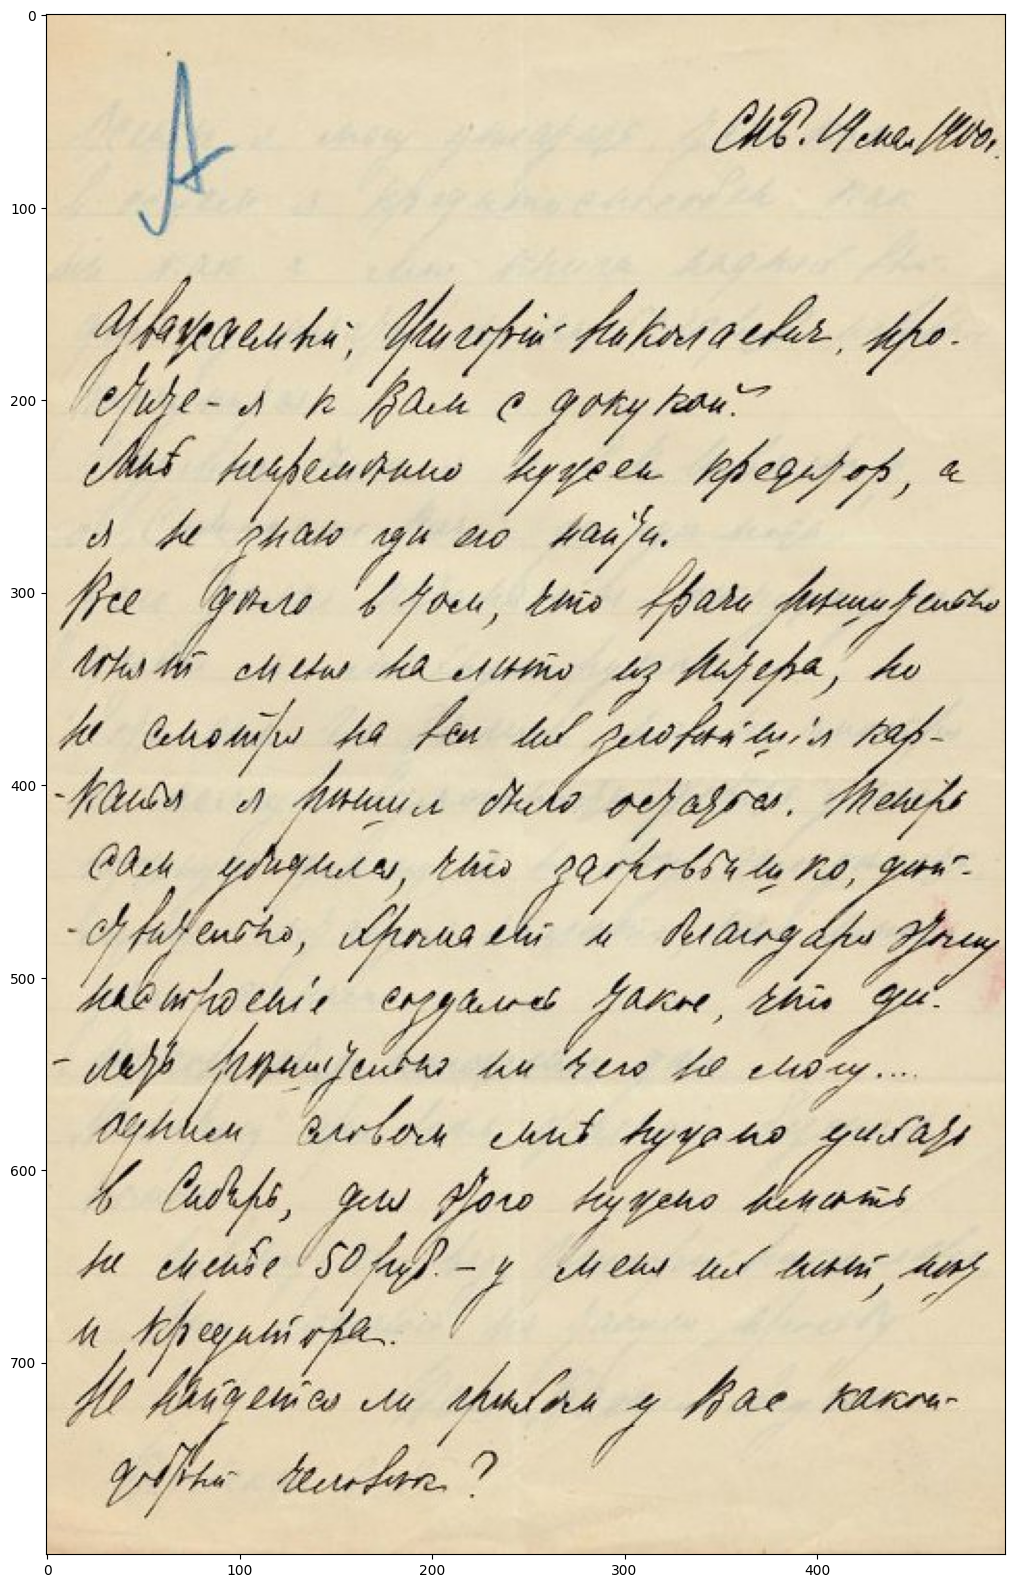

In [26]:
plt.figure(figsize=(20,20))
plt.imshow(img)
for line in baseline_seg.lines:
    plt.plot([b[0] for b in line.baseline], [b[1] for b in line.baseline])
    color = plt.gca().lines[-1].get_color()
    plt.plot([b[0] for b in line.boundary], [b[1] for b in line.boundary], color=color)
plt.show()